# 🧠 Text Preprocessing

## 📌 Project Overview
Text preprocessing is the essential first step in any NLP pipeline. It helps clean, normalize, and prepare raw text data for models — whether for traditional ML, deep learning, or LLMs.

In this notebook, we explore and compare several powerful text preprocessing techniques using:

- 🧰 NLTK
- ⚙️ SpaCy
- 🤗 Hugging Face Transformers

We will visualize, compare outputs, and analyze tradeoffs between these methods on real-world data.

## Imports

In [ ]:
# Base Libraries
import nltk
import spacy
import string
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# NLP
from nltk.corpus import twitter_samples

## Loading the data & Visualizing
We use NLTK’s `twitter_samples` dataset, which includes 10,000 tweets:
- 5,000 positive
- 5,000 negative

In [60]:
# Downloading the data
nltk.download('twitter_samples')
nltk.download('punkt')  # For tokenization
nltk.download('stopwords')
nltk.download('wordnet') # English DB to figure out base forms of words
nltk.download('omw-1.4') #  for more accurate lemmatization, improves results

[nltk_data] Downloading package twitter_samples to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package twitter_samples is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Loading positive tweets separately
positive_tweets = twitter_samples.strings('positive_tweets.json')
# Loading negative tweets separately
negative_tweets = twitter_samples.strings('negative_tweets.json')

# Loading the Positive & Negative tweets
tweets = twitter_samples.strings('positive_tweets.json') + twitter_samples.strings('negative_tweets.json')

# Visualizing
print("Example of first tweet loaded:", tweets[0])
print("Total number of tweets:", len(tweets))
print("Total number of positive tweets:", len(positive_tweets))
print("Total number of negative tweets:", len(negative_tweets))
print("Type of 'tweets'", type(tweets))
print("Type of each tweet", type(tweets[0]))

Example of first tweet loaded: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Total number of tweets: 10000
Total number of positive tweets: 5000
Total number of negative tweets: 5000
Type of 'tweets' <class 'list'>
Type of each tweet <class 'str'>


### Visual Summary

- **Tweet Lengths**: Most tweets contain between **5 and 15 words**, as expected from short-form social media text.
- **Sentiment Classes**: There is an **equal distribution** of positive and negative tweets — 5,000 each — making it ideal for balanced comparison and preprocessing evaluation.


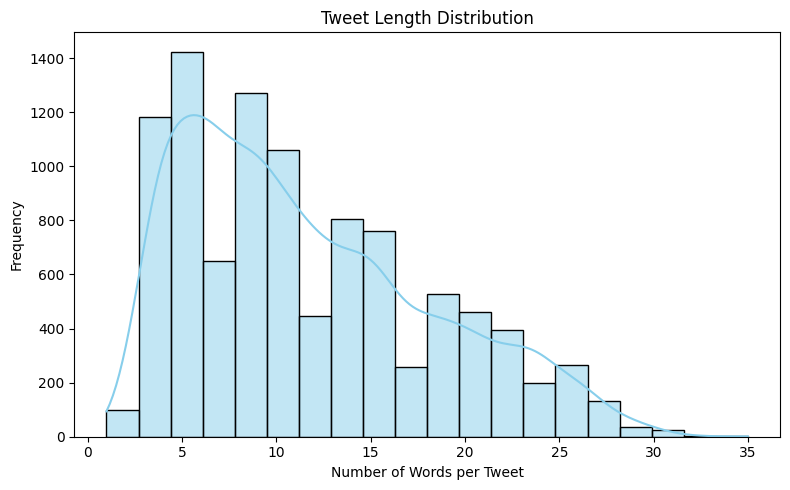

In [15]:
# Word count per tweet
tweet_lengths = [len(tweet.split()) for tweet in tweets]

plt.figure(figsize=(8, 5))
sns.histplot(tweet_lengths, bins=20, kde=True, color='skyblue')
plt.title("Tweet Length Distribution")
plt.xlabel("Number of Words per Tweet")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


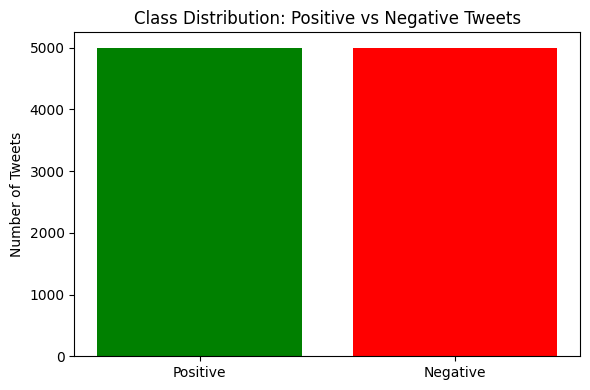

In [16]:
# Tweet counts
labels = ['Positive', 'Negative']
counts = [len(positive_tweets), len(negative_tweets)]

# Plot
plt.figure(figsize=(6,4))
plt.bar(labels, counts, color=['green', 'red'])
plt.title("Class Distribution: Positive vs Negative Tweets")
plt.ylabel("Number of Tweets")
plt.tight_layout()
plt.show()

## Vocabulary Analysis

### Tokenizing using TweetTokenizer from NLTK
Before settling on TweetTokenizer, we tested `word_tokenize` and encountered dependency issues (punkt). 
Even after fixing them, we chose `TweetTokenizer` for its superior handling of hashtags, emojis, mentions, and informal spellings which are common in Twitter data.

In [41]:
from nltk.tokenize import TweetTokenizer

# we set preserve_case to true, to keep words with their punctuation
# strip_handles = false, to keep the mentions in the tweets as @France_Inte
# reduce_len = True, to reduce exaggerated words in case their is any (eg."Soo" => "So")
tokenizer = TweetTokenizer(preserve_case=True, strip_handles=False, reduce_len=True)

first_tweet = tweets[0]
tokenized_first_tweet = tokenizer.tokenize(first_tweet)

print("Tweet:", first_tweet)
print("Tokenized:", tokenized_first_tweet)

Tweet: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tokenized: ['#FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


In [45]:
# Creating a list of all words in the tweets tokenized
all_tweet_tokens = [token for tweet in tweets for token in tokenizer.tokenize(tweet)]

print(len(all_tweet_tokens))

130055


In [47]:
# To calculate and see the count of occurrences of each token
from collections import Counter

token_freq = Counter(all_tweet_tokens)
print(token_freq.most_common(20))

[(':(', 4586), (':)', 3693), ('!', 2675), ('I', 2477), ('.', 2433), ('to', 2133), ('you', 2001), ('the', 1845), (',', 1698), ('a', 1515), ('and', 1274), ('(', 1262), ('?', 1225), ('for', 1140), ('my', 1113), ('it', 909), ('in', 902), ('is', 874), ('me', 854), ('i', 823)]


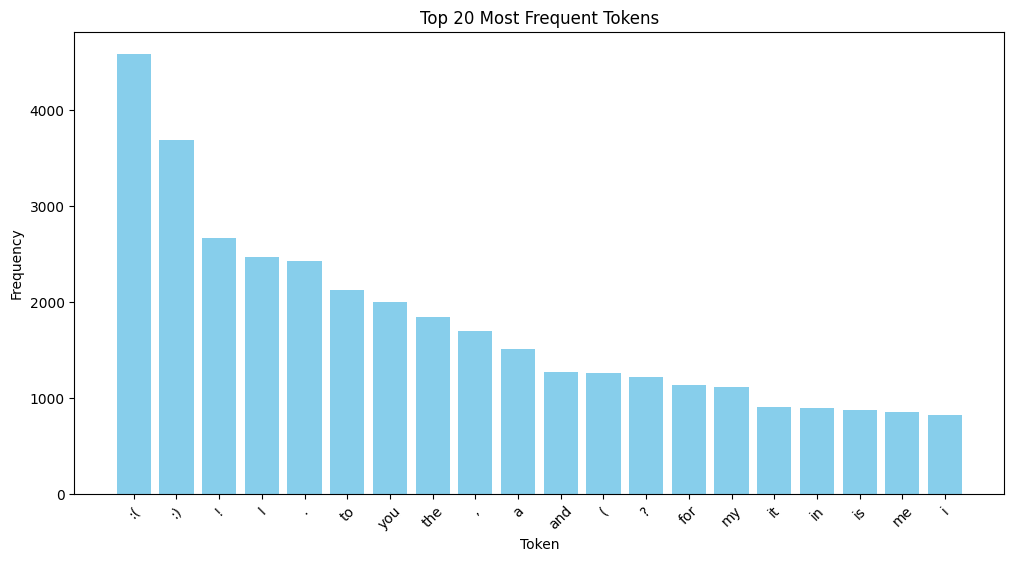

In [59]:
top_tokens = token_freq.most_common(20)
tokens, freqs = zip(*top_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens, freqs, color='skyblue')
plt.title("Top 20 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

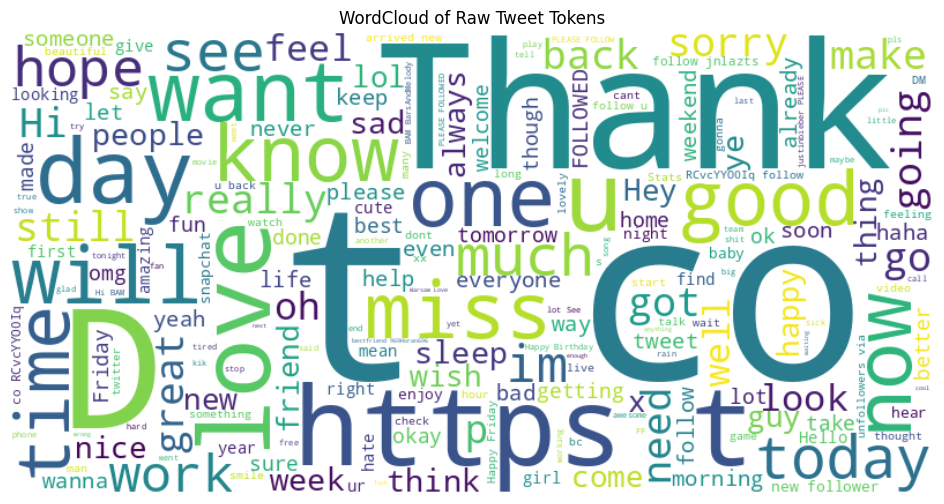

In [57]:
# Creating wordcloud for tokenized tweets 
from wordcloud import WordCloud

text_for_cloud = ' '.join(all_tweet_tokens)

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_for_cloud)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud of Raw Tweet Tokens")
plt.show()


## 1) NLTK Preprocessing Pipeline: 
- Tokenizes tweets using `TweetTokenizer`
- Removes punctuation, numbers, and non-alphabetic tokens
- Removes English stopwords
- Lemmatizes tokens using `WordNetLemmatizer`

In [82]:
## 1) Tokenize
from nltk.tokenize import TweetTokenizer

tweet = tweets[0]
print("Original Tweet: \n", first_tweet)

# Our focus is the context of the tweet, so remoced strip handles, and focused on words themselves without preserving the case
tokenizer = TweetTokenizer(preserve_case=False, strip_handles=True, reduce_len=True)
tweet_tokens = tokenizer.tokenize(tweet)
print("Tokenized Tweet: \n", tweet_tokens)

Original Tweet: 
 #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Tokenized Tweet: 
 ['#followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']


In [85]:
# 2) Remove Punctuation and numbers 

# Remove Punctuation
# Find any character that is NOT a letter, number, underscore (\w), or whitespace (\s)
tweet_tokens_punct_removed = [re.sub(r'[^\w\s]', '', token) for token in tweet_tokens]
print("Tokenized Tweet without Punct: \n", tweet_tokens_punct_removed)

# Remove Numbers (if any), keeping only alpha characters
tweet_token_no_nums = [token for token in tweet_tokens_punct_removed if token.isalpha()]
print("Tokenized Tweet without Numbers: \n", tweet_token_no_nums)

Tokenized Tweet without Punct: 
 ['followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', '']
Tokenized Tweet without Numbers: 
 ['followfriday', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week']


In [89]:
# 3) Remove Stopwords 
from nltk.corpus import stopwords

# Getting the English Stopwords
stop_words = set(stopwords.words('english'))
print("Stopwords:", stop_words)
tweet_tokens_no_stopwords = [token for token in tweet_token_no_nums if token not in stop_words]
print("Tokenized Tweet without Stopwords: \n", tweet_tokens_no_stopwords)


Stopwords; {'again', 'theirs', 'above', "she'd", 'these', 'further', 'had', 'where', 'him', 'm', 'at', 'mustn', 'will', 'be', 'my', 'over', 'ain', 'am', "couldn't", "you'd", 'needn', 'were', 'doing', 'your', 'it', 'before', 'up', 're', 'has', 'this', 'o', "she'll", 'weren', 'but', 'been', 'under', 'couldn', "we've", 'to', "didn't", "shouldn't", 'that', 'his', 'hers', 'or', 'so', "he'd", 'what', 'wouldn', 'mightn', 'own', 'shan', "she's", 've', 'few', 'wasn', "hasn't", 'd', "wouldn't", "they've", 'during', 'out', "doesn't", "he'll", 'themselves', 'a', 'on', 'very', "needn't", "you'll", 'against', 'are', 'didn', 'then', 'most', 'we', 'some', 'after', 'in', 'our', 'once', 'about', 'their', 'there', 'ma', 'you', 'here', 'each', 'itself', 'off', "should've", 'such', 'do', "it'd", 'those', 'until', "we'll", 'he', "aren't", 'haven', "that'll", 'does', "mustn't", 'with', "it's", 'which', 'same', 'if', 'yourself', "he's", "we'd", 'ourselves', "shan't", "don't", 'only', 'whom', 'won', 'no', "you

### Stemming vs. Lemmatization 

For word normalization: we compare **stemming** (PorterStemmer) with **lemmatization** (WordNetLemmatizer).

- **Stemming** uses heuristic rules to chop word endings.
- **Lemmatization** uses a dictionary to return the proper base word.

While stemming is faster, it often returns incomplete or non-real words (e.g., `engag`, `commun`). Lemmatization is slower but more linguistically accurate.

In [94]:
# 4.1) Stemming
from nltk.stem import PorterStemmer

stemmer = PorterStemmer()
tweet_tokens_stemmed = [stemmer.stem(token) for token in tweet_tokens_no_stopwords]
print("Stemmed Tweet: \n", tweet_tokens_stemmed)

# 4.2) Lemmatization
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()
tweet_tokens_lemmatized = [lemmatizer.lemmatize(token) for token in tweet_tokens_no_stopwords]
print("Lemmatized Tweet: \n", tweet_tokens_lemmatized)

Stemmed Tweet: 
 ['followfriday', 'top', 'engag', 'member', 'commun', 'week']
Lemmatized Tweet: 
 ['followfriday', 'top', 'engaged', 'member', 'community', 'week']


In [95]:
# NLTK Preprocessing function
def preprocess_nltk(text):
    # 1. Tokenize
    tokens = tokenizer.tokenize(text)

    # 2. Remove punctuation, numbers and non-alphabetic tokens
    tokens = [re.sub(r'[^\w\s]', '', token) for token in tokens]
    tokens = [token for token in tokens if token.isalpha()]

    # 3. Remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # 4. Lemmatize
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return tokens

In [97]:
# Testing
for i in range(5):
    print("Original:", tweets[i])
    print("Cleaned: ", preprocess_nltk(tweets[i]))
    print("-" * 50)

Original: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Cleaned:  ['followfriday', 'top', 'engaged', 'member', 'community', 'week']
--------------------------------------------------
Original: @Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
Cleaned:  ['hey', 'james', 'odd', 'please', 'call', 'contact', 'centre', 'able', 'assist', 'many', 'thanks']
--------------------------------------------------
Original: @DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
Cleaned:  ['listen', 'last', 'night', 'bleed', 'amazing', 'track', 'scotland']
--------------------------------------------------
Original: @97sides CONGRATS :)
Cleaned:  ['congrats']
--------------------------------------------------
Original: yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profil

### Trying NLTK Preprocessing on Data

In [ ]:
# Cleaning & Preprocessing first 1000 tweets using the nltk preprocessing function
preprocessed_tweets_nltk = [preprocess_nltk(tweet) for tweet in tweets[:1000]]

In [102]:
# Compare sizes of tokenized before and after preprocessing

# Tokenized tweets with no cleaning
original_tokens = [token for tweet in tweets[:1000] for token in tokenizer.tokenize(tweet)]

# Preprocessed tweets
cleaned_tokens = [token for tweet in preprocessed_tweets_nltk for token in tweet]

vocab_original = set(original_tokens)
vocab_cleaned = set(cleaned_tokens)

print("Original Vocab Size:", len(vocab_original))
print("After NLTK Cleaning Vocab Size:", len(vocab_cleaned))

Original Vocab Size: 2754
After NLTK Cleaning Vocab Size: 2126


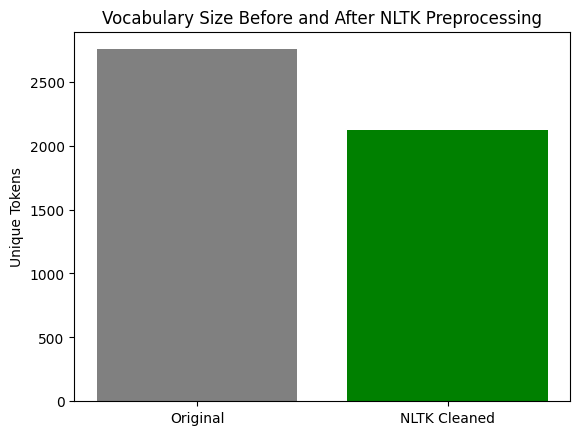

In [103]:
labels = ['Original', 'NLTK Cleaned']
sizes = [len(vocab_original), len(vocab_cleaned)]

plt.bar(labels, sizes, color=['gray', 'green'])
plt.title('Vocabulary Size Before and After NLTK Preprocessing')
plt.ylabel('Unique Tokens')
plt.show()

In [108]:
# Top 20 tokens after nltk preprocessing
token_freq_nltk_cleaned = Counter(cleaned_tokens)
print(token_freq_nltk_cleaned.most_common(20))

[('D', 135), ('follow', 117), ('u', 99), ('love', 70), ('thanks', 66), ('back', 55), ('day', 48), ('like', 46), ('hi', 46), ('thank', 43), ('good', 42), ('im', 37), ('great', 36), ('know', 35), ('new', 34), ('get', 33), ('week', 31), ('happy', 30), ('see', 30), ('hope', 29)]


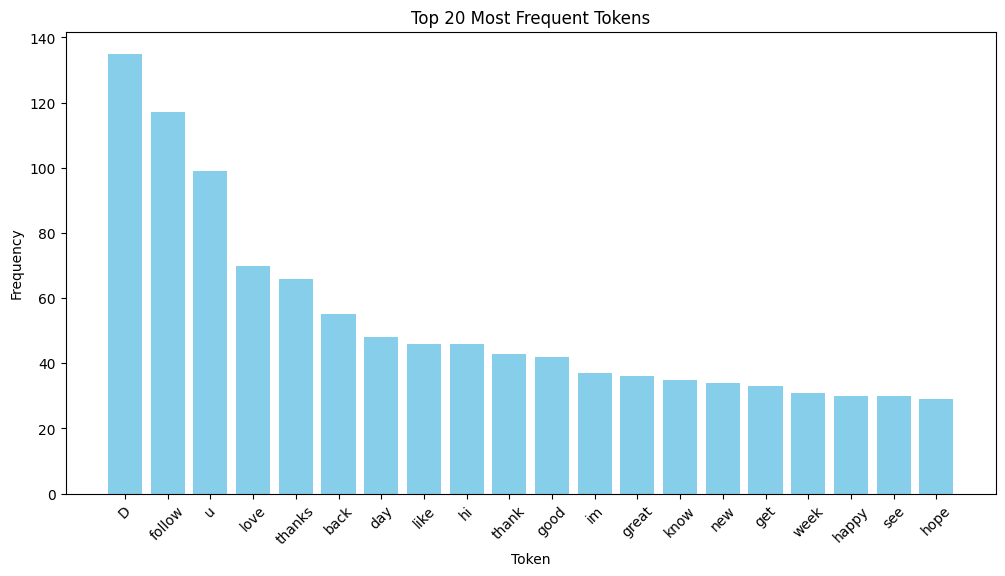

In [111]:
top_nltk_cleaned_tokens = token_freq_nltk_cleaned.most_common(20)
tokens, freqs = zip(*top_nltk_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens, freqs, color='skyblue')
plt.title("Top 20 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

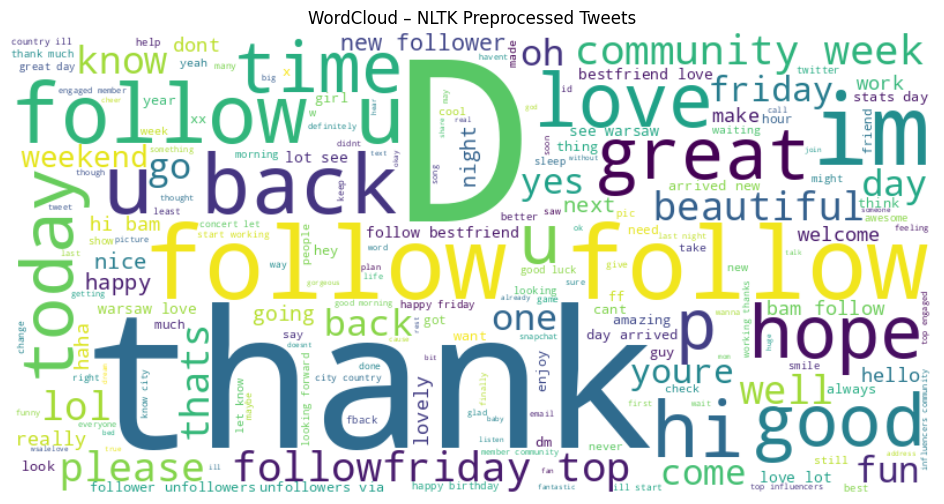

In [110]:
# Word Cloud for NLTK Preprocessed Tokens
all_nltk_cleaned_tokens = ' '.join(cleaned_tokens)
wordcloud_nltk = WordCloud(width=800, height=400, background_color='white').generate(all_nltk_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_nltk, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud – NLTK Preprocessed Tweets")
plt.show()

## 2) SpaCy Preprocessing Pipeline:
We apply a custom SpaCy preprocessing function to:
- Tokenize the text
- Remove:
  - Stopwords 
  - Punctuation
  - Non-alphabetic tokens (e.g., numbers, emojis)
- Convert words to their **lemmatized** (base) form
- **Lowercase** all tokens for normalization

In [122]:
# 1) Process using SpaCy model
# Loading SpaCy's small English model
nlp = spacy.load("en_core_web_sm") 

tweet = tweets[0]
spacy_doc = nlp(tweet)

print("Original Tweet:", tweet)
print("SpaCy Tokens:", [token.text for token in spacy_doc])
print(type(spacy_doc))

Original Tweet: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
SpaCy Tokens: ['#', 'FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']
<class 'spacy.tokens.doc.Doc'>


In [130]:
# Identifying stopwords using is_stop
for token in spacy_doc:
    print(f"{token.text:15} | Is Stopword? → {token.is_stop}")

# Removing stopword 
tokens_spacy_no_stopwords = []
for token in spacy_doc:
    if not token.is_stop:
        tokens_spacy_no_stopwords.append(token)

print()
print("SpaCy Tokens:\n", [token.text for token in spacy_doc])
print("Tokens without stopwords:\n", tokens_spacy_no_stopwords)

#               | Is Stopword? → False
FollowFriday    | Is Stopword? → False
@France_Inte    | Is Stopword? → False
@PKuchly57      | Is Stopword? → False
@Milipol_Paris  | Is Stopword? → False
for             | Is Stopword? → True
being           | Is Stopword? → True
top             | Is Stopword? → True
engaged         | Is Stopword? → False
members         | Is Stopword? → False
in              | Is Stopword? → True
my              | Is Stopword? → True
community       | Is Stopword? → False
this            | Is Stopword? → True
week            | Is Stopword? → False
:)              | Is Stopword? → False

SpaCy Tokens:
 ['#', 'FollowFriday', '@France_Inte', '@PKuchly57', '@Milipol_Paris', 'for', 'being', 'top', 'engaged', 'members', 'in', 'my', 'community', 'this', 'week', ':)']
Tokens without stopwords:
 [#, FollowFriday, @France_Inte, @PKuchly57, @Milipol_Paris, engaged, members, community, week, :)]


In [139]:
# Removing Punctuation and allowing only alpha 
tokens_spacy_no_punctuation = []
for token in tokens_spacy_no_stopwords:
    if not token.is_punct and token.is_alpha:
        tokens_spacy_no_punctuation.append(token)

print()
print("SpaCy Tokens without stopwords:\n", [token for token in tokens_spacy_no_stopwords])
print("Tokens without Punctuation:\n", tokens_spacy_no_punctuation)


SpaCy Tokens without stopwords:
 [#, FollowFriday, @France_Inte, @PKuchly57, @Milipol_Paris, engaged, members, community, week, :)]
Tokens without Punctuation:
 [FollowFriday, engaged, members, community, week]


In [140]:
# Lemmatization
tokens_spacy_lemmatized = []
for token in tokens_spacy_no_punctuation:
        tokens_spacy_lemmatized.append(token.lemma_)

print()
print("SpaCy Tokens without Punctuation:\n", [token for token in tokens_spacy_no_punctuation])
print("Tokens Lemmatized:\n", tokens_spacy_lemmatized)


SpaCy Tokens without Punctuation:
 [FollowFriday, engaged, members, community, week]
Tokens Lemmatized:
 ['FollowFriday', 'engage', 'member', 'community', 'week']


In [145]:
# Final Spacy Preprocessing Function
def preprocess_spacy(text):
    doc = nlp(text)

    cleaned_tokens_spacy = []
    for token in doc: 
        if not token.is_stop and not token.is_punct and token.is_alpha:
            cleaned_tokens_spacy.append(token.lemma_.lower())

    return cleaned_tokens_spacy

In [146]:
for i in range(5):
    print("Original:", tweets[i])
    print("Cleaned: ", preprocess_spacy(tweets[i]))
    print("-" * 50)

Original: #FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)
Cleaned:  ['followfriday', 'engage', 'member', 'community', 'week']
--------------------------------------------------
Original: @Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!
Cleaned:  ['hey', 'james', 'odd', 'contact', 'centre', 'able', 'assist', 'thank']
--------------------------------------------------
Original: @DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!
Cleaned:  ['listen', 'night', 'bleed', 'amazing', 'track', 'scotland']
--------------------------------------------------
Original: @97sides CONGRATS :)
Cleaned:  ['congrats']
--------------------------------------------------
Original: yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days
Cleaned:  ['yeaaaah', 'yipp

### Trying SpaCy Preprocessing on Data

In [147]:
# Cleaning & Preprocessing first 1000 tweets using the spacy preprocessing function
preprocessed_tweets_spacy = [preprocess_spacy(tweet) for tweet in tweets[:1000]]

In [148]:
# Compare sizes of tokenized before and after preprocessing

# Tokenized tweets with no cleaning
original_tokens = [token for tweet in tweets[:1000] for token in tokenizer.tokenize(tweet)]

# Preprocessed tweets
cleaned_tokens = [token for tweet in preprocessed_tweets_spacy for token in tweet]

vocab_original = set(original_tokens)
vocab_cleaned = set(cleaned_tokens)

print("Original Vocab Size:", len(vocab_original))
print("After NLTK Cleaning Vocab Size:", len(vocab_cleaned))

Original Vocab Size: 2754
After NLTK Cleaning Vocab Size: 1862


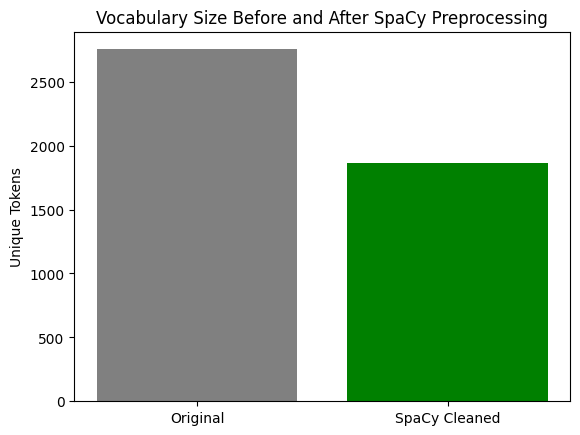

In [150]:
labels = ['Original', 'SpaCy Cleaned']
sizes = [len(vocab_original), len(vocab_cleaned)]

plt.bar(labels, sizes, color=['gray', 'green'])
plt.title('Vocabulary Size Before and After SpaCy Preprocessing')
plt.ylabel('Unique Tokens')
plt.show()

In [151]:
# Top 20 tokens after nltk preprocessing
token_freq_spacy_cleaned = Counter(cleaned_tokens)
print(token_freq_spacy_cleaned.most_common(20))

[('follow', 124), ('thank', 107), ('u', 76), ('love', 73), ('amp', 58), ('good', 49), ('like', 48), ('day', 46), ('hi', 46), ('know', 36), ('great', 36), ('new', 35), ('week', 31), ('happy', 30), ('hope', 29), ('today', 28), ('time', 27), ('look', 26), ('go', 25), ('community', 24)]


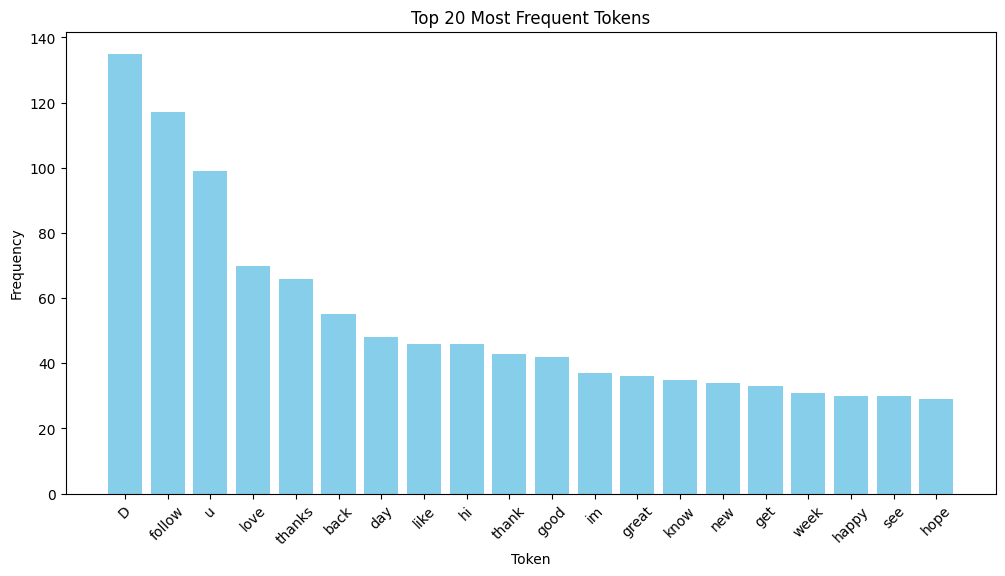

In [152]:
top_spacy_cleaned_tokens = token_freq_spacy_cleaned.most_common(20)
tokens, freqs = zip(*top_nltk_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.bar(tokens, freqs, color='skyblue')
plt.title("Top 20 Most Frequent Tokens")
plt.xticks(rotation=45)
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.show()

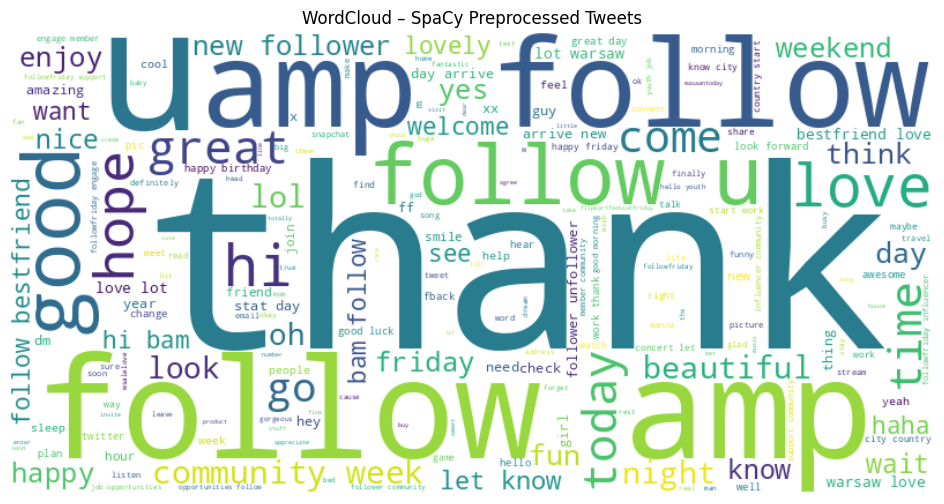

In [155]:
# Word Cloud for Spacy Preprocessed Tokens
all_spacy_cleaned_tokens = ' '.join(cleaned_tokens)
wordcloud_spacy = WordCloud(width=800, height=400, background_color='white').generate(all_spacy_cleaned_tokens)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud_spacy, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud – SpaCy Preprocessed Tweets")
plt.show()